In [1]:
import numpy as np
import pandas as pd
import h2o
from h2o.estimators import H2OSupportVectorMachineEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from h2o.grid.grid_search import H2OGridSearch
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Mikhail\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = pd.read_csv('C:\\Users\\Mikhail\\Documents\\Data 606\\cleaned_data.csv')

#Sampling the data in consideration of my local machine's memory
data_sample = data.sample(frac = .5)

In [3]:
"""
From text analysis of Level 4 descriptions, encoding features based on terms that are disproportionally present or not present 
in level 4 descriptions. Also changing the day of week to be either a weekday or weekend and dropping Sunrise_Sunset 
"""
def feature_add(df):
    
    df['earlier_accident'] = 0
    df.loc[df['Description'].str.contains('earlier'), 'earlier_accident'] = 1
    
    df['road_reopened'] = 0
    df.loc[df['Description'].str.contains('re-opened'), 'road_reopened'] = 1
    
    df['emergency'] = 0
    df.loc[df['Description'].str.contains('emergency'), 'emergency'] = 1
    
    df['near_locator'] = 0
    df.loc[df['Description'].str.contains('near'), 'near_locator'] = 1
    
    df.loc[df['Description'].str.contains('jackknifed'), 'jacknifed'] = 1
    
    df['detour'] = 0
    df.loc[df['Description'].str.contains('detour'), 'detour'] = 1
    
    df['weekend'] = 0
    df.loc[df['Day_of_Week'] >= 5, 'weekend'] = 1
    
    df.drop(['Day_of_Week', 'Sunrise_Sunset'], axis = 1, inplace = True)


    return df

In [4]:
#Dropping all 1's. They are a miniscule minority and not a predictive priority. Also adding in the features
extra_data = feature_add(data_sample)
extra_data = extra_data[extra_data['Severity'] > 1]

In [5]:
#Checking for extreme sparsity
def feature_freq(df):
    
    excluded_cols = ['Temperature_F', 'Humidity', 'Pressure_in', 'Visibility_mi', 'Wind_Speed_mph', 'Severity', 'Description', 'TMC', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Distance_mi', 'Street', 'City', 'County', 'State', 'Zipcode', 'Weather_Condition', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Time_Elapsed', 'Year_', 'POP_PER_SQ_MI', 'Month', 'Hour', 'Side', 'Timezone']
    
    positive_features = {}
    for c in df.columns:
        if c not in excluded_cols:
            counts = df[c].value_counts(normalize = True)
            try:
                positives = counts.loc[1]
                positive_features[c] = positives
            except KeyError:
                positive_features[c] = np.nan
            
    return {k: v for k, v in sorted(positive_features.items(), key=lambda item: item[1])}

feature_freq(extra_data)

{'construction_area': 1.574868252427758e-05,
 'Roundabout': 5.3151803519436826e-05,
 'detour': 0.00017717267839812277,
 'Bump': 0.00018110984902919216,
 'Traffic_Calming': 0.0004527746225729804,
 'jacknifed': 0.0004980520848302785,
 'emergency': 0.0009449209514566547,
 'spillage': 0.0010433502172333897,
 'No_Exit': 0.0011811511893208184,
 'road_reopened': 0.0013150149907771777,
 'ramp_blocked': 0.0015768368377432926,
 'earlier_accident': 0.0027619251976951802,
 'Give_Way': 0.0027717681242728537,
 'serious': 0.003433212790292512,
 'County_Hwy': 0.004846657046846425,
 'Hour_': 0.005293525913472801,
 'Heavy_Precip': 0.007569210538230911,
 'Other_Cond': 0.0075869278060707234,
 'multi_vehicle': 0.008171597644784529,
 'Railway': 0.009193293423547036,
 'Amenity': 0.014266337781679952,
 'Stop': 0.015270316292602648,
 'Impaired_Visibility': 0.0202547743115365,
 'Station': 0.02185129700243514,
 'Month_': 0.03604873429807138,
 'Junction': 0.05157102951106247,
 'near_locator': 0.07185336401701645,

I will drop the features for construction area, roundabout, bump, traffic calming, and turning loop. Some of the other very sparse features were found to be disproportionally present in level 4 accidents and will undoubtedly grow in density with synthetic oversampling.

In [6]:
#Dropping continuous columns and extraneous columns before chi-squared testing
columns_to_drop = ['construction_area', 'Roundabout', 'Bump', 'Traffic_Calming', 'Turning_Loop', 'Start_Lat', 'Start_Lng', 'Temperature_F', 'Humidity', 'Pressure_in', 'Visibility_mi', 'Wind_Speed_mph', 'Severity', 'Description', 'TMC', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Distance_mi', 'Street', 'City', 'County', 'State', 'Zipcode', 'Weather_Condition', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Time_Elapsed', 'Year_', 'POP_PER_SQ_MI']

X = extra_data.drop(columns_to_drop, axis=1)
y = extra_data['Severity']

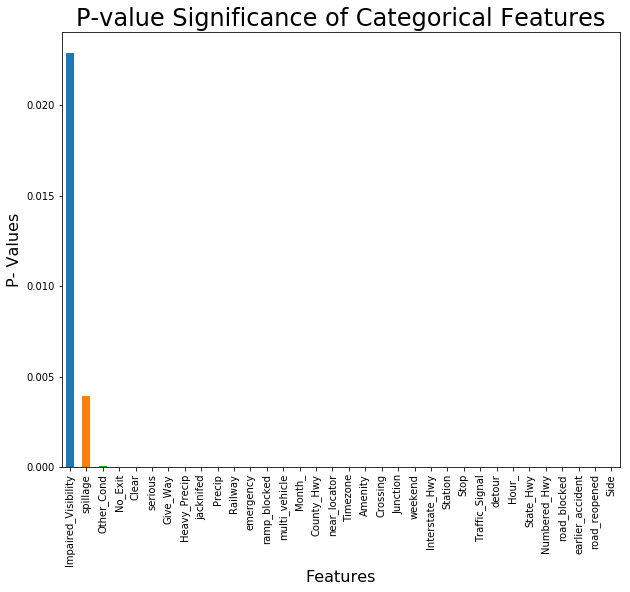

In [7]:
chi_scores = chi2(X,y)

p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
ind_columns = list(p_values[p_values > .05].index)

p_values.plot.bar()
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.title('P-value Significance of Categorical Features', size = 24)
plt.ylabel('P- Values', size = 16)
plt.xlabel('Features', size = 16)
plt.savefig('C:\\Users\\Mikhail\\Documents\\Data 606\\chi2_results')

In [8]:
#Dropping statistically insignificant features if there are any
extra_data.drop(ind_columns, axis = 1, inplace = True)
"""
Dropping redundant and sparse ones features, as well as ones that were 
relevant for geographic analysis, but not for model training
"""
extra_data = extra_data.drop(['construction_area', 'Roundabout', 'Bump', 'Traffic_Calming', 'Turning_Loop', 'Description', 'TMC', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Distance_mi', 'Street', 'City', 'County', 'State', 'Zipcode', 'Weather_Condition', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Time_Elapsed', 'Year_'], axis = 1)

C:\Users\Mikhail\Anaconda\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
#Train, validation, and test splitting
feats = extra_data.drop('Severity', axis = 1)
target = extra_data['Severity']

x_train, x_test, y_train, y_test = train_test_split(feats, target, test_size = .2, random_state = 1)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = .3, random_state = 1)

In [10]:
#Synthetically generating more minority samples
maj_samples = len(y_train[y_train == 2])
sm = SMOTE(random_state = 11, n_jobs = -1, sampling_strategy = {2 : maj_samples, 3: maj_samples, 4: maj_samples}, k_neighbors = 3)

x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

In [11]:
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from C:\Users\Mikhail\Anaconda\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Mikhail\AppData\Local\Temp\tmp2dao4hut
  JVM stdout: C:\Users\Mikhail\AppData\Local\Temp\tmp2dao4hut\h2o_Mikhail_started_from_python.out
  JVM stderr: C:\Users\Mikhail\AppData\Local\Temp\tmp2dao4hut\h2o_Mikhail_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,3 months and 4 days
H2O cluster name:,H2O_from_python_Mikhail_yajlkj
H2O cluster total nodes:,1
H2O cluster free memory:,1.738 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [12]:
#Ensuring columns have the same names and categorical columns are encoded as such
x_train_res_df = pd.DataFrame(x_train_res)
x_validate_df = pd.DataFrame(x_validate)
x_test_df = pd.DataFrame(x_test)
x_train_res_df.columns = list(feats.columns)
x_validate_df.columns = list(feats.columns)
x_test_df.columns = list(feats.columns)
x_train_res_df['Severity'] = y_train_res
x_validate_df['Severity'] = y_validate
x_test_df['Severity'] = y_test

h2o_train = h2o.H2OFrame(x_train_res_df)
h2o_valid = h2o.H2OFrame(x_validate_df)
h2o_test = h2o.H2OFrame(x_test_df)

h2o_train['Severity'] = h2o_train['Severity'].asfactor()
h2o_valid['Severity'] = h2o_valid['Severity'].asfactor()
h2o_test['Severity'] = h2o_test['Severity'].asfactor()

cont_columns = ['POP_PER_SQ_MI', 'Wind_Speed_mph', 'Visibility_mi', 'Pressure_in', 'Humidity', 'Temperature_F', 'Hour']
#All these have the same column names
for c in h2o_train.columns:
    if c not in cont_columns:
        h2o_train[c] = h2o_train[c].asfactor()
        h2o_valid[c] = h2o_valid[c].asfactor()
        h2o_test[c] = h2o_test[c].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


Since the model will be training on artificially balanced data, the max depth of the trees should be kept low to prevent overfitting to this. There are also a relatively small amount of features, so the number of trees does not need to be too high. H2o gives a certain number of metrics to sort models by, I am going with mean per class accuracy as it is not affected by class imbalance, which is what I am looking for. In addition, I'm using the roc_auc score of my validation data. I am not cross-validating as the training data is artificially balanced, plus h2o will reflect validation frame metrics this way. 

In [13]:
def parameter_tuning():
    
    drf_params = {'ntrees' : [15,20,25,30,35,40,45,50], 'max_depth' : [4,5,6,7,8,9,10]}

    criteria = {"strategy": "RandomDiscrete", 
                "stopping_rounds": 5,
                "stopping_tolerance": 0.01,
                "stopping_metric": "misclassification",
                "max_runtime_secs" : 3600}

    est = H2ORandomForestEstimator(categorical_encoding = 'label_encoder', nfolds = 0)

    grid_search = H2OGridSearch(model = est, hyper_params = drf_params, search_criteria = criteria)
    
    features = list(h2o_train.columns)
    features.remove('Severity')

    grid_search.train(x = features, y = 'Severity', training_frame = h2o_train, validation_frame = h2o_valid)
    grid_results = grid_search.get_grid(sort_by = 'mean_per_class_accuracy', decreasing = True)
    sorted_metrics = grid_results.sorted_metric_table()
    
    print('\n')
    print('Top 3 model parameters and mean per-class accuracy:\n')
    for trees, depth, acc in zip(sorted_metrics['ntrees'].tolist()[:3], sorted_metrics['max_depth'].tolist()[:3], sorted_metrics['mean_per_class_accuracy'].tolist()[:3]):
        print('Number of trees: {}'.format(trees))
        print('Max Depth: {}'.format(depth))
        print('Mean per-class Accuracy: {}\n'.format(round(float(acc), 3)))
    
    model_one = h2o.get_model(sorted_metrics['model_ids'][0])
    model_two = h2o.get_model(sorted_metrics['model_ids'][1])
    model_three = h2o.get_model(sorted_metrics['model_ids'][2])
    
    #Each model's predictions
    m1_predicts = [int(p[0]) for p in h2o.as_list(model_one.predict(h2o_valid)['predict'], use_pandas = False, header = False)]
    m2_predicts = [int(p[0]) for p in h2o.as_list(model_two.predict(h2o_valid)['predict'], use_pandas = False, header = False)]
    m3_predicts = [int(p[0]) for p in h2o.as_list(model_three.predict(h2o_valid)['predict'], use_pandas = False, header = False)]
    
    #Probability of each class per model
    m1_probs = h2o.as_list(model_one.predict(h2o_valid), use_pandas = True)[['p2', 'p3', 'p4']].values
    m2_probs = h2o.as_list(model_two.predict(h2o_valid), use_pandas = True)[['p2', 'p3', 'p4']].values
    m3_probs = h2o.as_list(model_three.predict(h2o_valid), use_pandas = True)[['p2', 'p3', 'p4']].values

    m1_auc = roc_auc_score(y_validate, m1_probs, multi_class = 'ovr')
    m2_auc = roc_auc_score(y_validate, m2_probs, multi_class = 'ovr')
    m3_auc = roc_auc_score(y_validate, m3_probs, multi_class = 'ovr')
    
    print('\n')
    print('Model 1 ROC_AUC Score: {}'.format(round(m1_auc, 3)))
    print('Model 2 ROC_AUC Score: {}'.format(round(m2_auc, 3)))
    print('Model 3 ROC_AUC Score: {}'.format(round(m3_auc, 3)))

    return model_one, model_two, model_three      

In [14]:
best_model, second_model, third_model = parameter_tuning()

drf Grid Build progress: |████████████████████████████████████████████████| 100%


Top 3 model parameters and mean per-class accuracy:

Number of trees: 25
Max Depth: 7
Mean per-class Accuracy: 0.776

Number of trees: 35
Max Depth: 8
Mean per-class Accuracy: 0.774

Number of trees: 30
Max Depth: 6
Mean per-class Accuracy: 0.773

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


Model 1 ROC_AUC Score: 0.943
Model 2 ROC_AUC Score: 0.942
Model 3 ROC_AUC Score: 0.941


The roc_auc scores closely mirror the mean accuracies, so there is assurance that these are in fact the top 3 models. Neither the maximum amount of trees or max depth were used in the optimimum models, proving that moderating these hyperparamaters is the correct approach to achieve the best results. If all of the top models had ntrees >= 45 or max depth >= 9, I would consider extending the hyperparameter grid out further. To take a closer look at the exact results, here are the confusion matrices for each model. The order is the best through the third best model. "0" on the X-axis refers to class 2, "1" refers to class 3, "2" refers to class 4, and "3" is a cumulative result.

In [15]:
best_model.confusion_matrix(h2o_valid), second_model.confusion_matrix(h2o_valid), third_model.confusion_matrix(h2o_valid)


Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,2,3,4,Error,Rate
0,76441.0,2120.0,2367.0,0.055444,"4,487 / 80,928"
1,3213.0,27971.0,9365.0,0.310193,"12,578 / 40,549"
2,20.0,114.0,304.0,0.305936,134 / 438
3,79674.0,30205.0,12036.0,0.141074,"17,199 / 121,915"



Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,2,3,4,Error,Rate
0,76272.0,2085.0,2571.0,0.057533,"4,656 / 80,928"
1,3154.0,27564.0,9831.0,0.320230,"12,985 / 40,549"
2,21.0,111.0,306.0,0.301370,132 / 438
3,79447.0,29760.0,12708.0,0.145782,"17,773 / 121,915"



Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,2,3,4,Error,Rate
0,76503.0,1919.0,2506.0,0.054678,"4,425 / 80,928"
1,3245.0,26588.0,10716.0,0.344299,"13,961 / 40,549"
2,23.0,100.0,315.0,0.280822,123 / 438
3,79771.0,28607.0,13537.0,0.151819,"18,509 / 121,915"


(, , )

My models are extremely robust at predicting occurences of level 2 accidents, with modest success predicting level 3 and level 4, despite a huge class imbalance. If less disruptive accidents can be thought of as "negative" results and more disruptive ones are thought of as "positive" results, my model also does a good job minimizing type II error for level 3 and 4, which is important in a functional context of this model. Overall, the results are decent given the difficult problem of detecting extreme class minority instances in a multiclassification problem without compromising too much in detection of other instances. I will choose the best model here.

In [20]:
def model_testing(model):
    
    predictions = [int(p[0]) for p in h2o.as_list(model.predict(h2o_test)['predict'], use_pandas = False, header = False)]
    probabilities = h2o.as_list(model.predict(h2o_test), use_pandas = True)[['p2', 'p3', 'p4']].values
    mean_acc = balanced_accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average = 'macro')
    auc = roc_auc_score(y_test, probabilities, multi_class = 'ovr')
    
    print('\n')
    print('Mean per-class accuracy on test data: {}\n'.format(round(mean_acc, 3)))
    print('F1 score on test data: {}\n'.format(round(f1, 3)))
    print('Roc_AUC score on test data: {}'.format(round(auc, 3)))
    
    return

model_testing(best_model)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


Mean per-class accuracy on test data: 0.763

F1 score on test data: 0.598

Roc_AUC score on test data: 0.941


In [21]:
#Test data confusion matrix
best_model.confusion_matrix(h2o_test)


Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,2,3,4,Error,Rate
0,63767.0,1723.0,1977.0,0.054842,"3,700 / 67,467"
1,2587.0,23502.0,7671.0,0.303851,"10,258 / 33,760"
2,18.0,112.0,239.0,0.352304,130 / 369
3,66372.0,25337.0,9887.0,0.138667,"14,088 / 101,596"


Modeling holds up for testing data. Decent results given circumstances, but I want to see if I can do better. I will try a penalized SVM model using a one vs. rest classification method. H2o only has support for binary classification, so I will have to code a way to train 3 different models as OVR. H2o is significantly faster than sklearn due to its built-in parallel processing, so this is best way to proceed despite some of the extra effort.

In [52]:
def ovr_svm(train_array, test_array, level):
    
    cols_to_scale = ['Side', 'Timezone', 'Temperature_F', 'Humidity', 'Pressure_in', 'Visibility_mi', 'Wind_Speed_mph', 'POP_PER_SQ_MI']
    
    #Getting data into h2o and preprocessing
    scaler = MinMaxScaler()
    train_array[cols_to_scale] = scaler.fit_transform(train_array[cols_to_scale])
    test_array[cols_to_scale] = scaler.fit_transform(test_array[cols_to_scale])

    #Grid search is extremely time consuming, these are a good assumption for hyperparameters
    svc = H2OSupportVectorMachineEstimator(hyper_param = 15, gamma = .5)
    
    predictions_df = pd.DataFrame(index = range(len(test_array)))
    
    #Making this into a binary classification problem with the specified level
    train_array.loc[train_array['Severity'] == level, 'Severity'] = 1
    train_array.loc[train_array['Severity'] > 1, 'Severity'] = 0
    test_array.loc[test_array['Severity'] == level, 'Severity'] = 1
    test_array.loc[test_array['Severity'] > 1, 'Severity'] = 0

    h2o_train_ovr_df = h2o.H2OFrame(train_array)
    h2o_test_ovr_df = h2o.H2OFrame(test_array)
    h2o_train_ovr_df['Severity'] = h2o_train_ovr_df['Severity'].asfactor()
    h2o_test_ovr_df['Severity'] = h2o_test_ovr_df['Severity'].asfactor()

    x = list(h2o_train_ovr_df.columns)
    x.remove('Severity')
    svc.train(x = x, y = 'Severity', training_frame = h2o_train_ovr_df)
    predictions = svc.predict(h2o_test_ovr_df)
    predictions_df['level'] = h2o.as_list(predictions, use_pandas = True)['predict']
        
    return predictions_df

In [56]:
def svm_predictions(train_array, test_array):
    #SVM is a more expensive algorithm
    train_array['Severity'] = y_train
    train_array_samp = train_array.sample(frac = .2)
    test_array_samp = test_array.sample(frac = .12)
    
    level_predictions = pd.DataFrame(index = range(len(test_array_samp)))
    
    #Filling predictions dataframe for each predicted instance of each class
    for i in range(2,5):
        results = ovr_svm(train_array_samp.copy(), test_array_samp.copy(), i)
        level_predictions['predicts_{}'.format(i)] = results
        
    level_predictions['Tie'] = 0
    
    #Not very elegant, but item assignment is not allowed in the .itertuples() method
    series_values = []
    for t in level_predictions.itertuples(index = False):
        if t[0] == 1 and t[1] == 1:
            series_values.append(5)
        elif t[0] == 1 and t[2] == 1:
            series_values.append(5)
        elif t[1] == 1 and t[2] == 1:
            series_values.append(5)
        else:
            series_values.append(0)
    
    #Assigning final prediction to be which svc indicates a positive class. "Tie" is if multiple models predict a positive class
    level_predictions['Tie'] = series_values
    level_predictions['Final_predict'] = level_predictions.idxmax(axis = 1)
    
    #Adding on predictions from the rf model in cases of a tie. Also making sure data types are the same
    h2o_test_array_samp = h2o.H2OFrame(test_array_samp)
    
    for c in h2o_test_array_samp.columns:
        if c not in cont_columns:
            h2o_test_array_samp[c] = h2o_test_array_samp[c].asfactor()
    
    level_predictions[['rf_p2', 'rf_p3', 'rf_p4']] = h2o.as_list(best_model.predict(h2o_test_array_samp), use_pandas = True)[['p2', 'p3', 'p4']]
    
    #All level 4 predictions will be the final one, and other ties defer to the RF prediction class
    level_predictions.loc[level_predictions['Final_predict'] == 'predicts_2', 'Final_predict'] = '2'
    level_predictions.loc[level_predictions['Final_predict'] == 'predicts_3', 'Final_predict'] = '3'
    level_predictions.loc[level_predictions['Final_predict'] == 'predicts_4', 'Final_predict'] = '4'
    level_predictions.loc[level_predictions['Final_predict'] == 'Tie', 'Final_predict'] = level_predictions.loc[level_predictions['Final_predict'] == 'Tie', 'rf_p2' : 'rf_p4'].idxmax(axis = 1)
    
    level_predictions['Final_predict'] = level_predictions['Final_predict'].str[-1].astype(int)
    level_predictions.loc[level_predictions['predicts_4'] == 1, 'Final_predict'] = 4
    
    balanced_acc = round(balanced_accuracy_score(test_array_samp['Severity'], level_predictions['Final_predict']),3)
    f1 = round(f1_score(test_array_samp['Severity'], level_predictions['Final_predict'], average = 'macro'),3)
    
    print('\n')
    print('Mean accuracy score for SVM model: {}\n'.format(balanced_acc))
    print('F1 score for SVM Model: {}\n'.format(f1))
    
    
    return level_predictions, test_array_samp['Severity']

Training on the synthetically generated dataset produces a tie in predicted classes about 75-80% of the time, which I am filling in with predictions from my RF model. To produce a distinguishably different model, I have to use the imbalanced training data.

In [57]:
p_df, true_values = svm_predictions(x_train.copy(), x_validate_df.copy())
confusion_matrix(true_values, p_df['Final_predict'])

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
psvm Model Build progress: |██████████████████████████████████████████████| 100%
psvm prediction progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
psvm Model Build progress: |██████████████████████████████████████████████| 100%
psvm prediction progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
psvm Model Build progress: |██████████████████████████████████████████████| 100%
psvm prediction progress: |███████████████████████████████████████████████| 100%
Parse progress: |███████████

array([[8295,  224, 1313],
       [1278,  891, 2562],
       [  11,    6,   50]], dtype=int64)

In [61]:
test_p_df, test_true_values = svm_predictions(x_train.copy(), x_test_df.copy())
confusion_matrix(test_true_values, test_p_df['Final_predict'])

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
psvm Model Build progress: |██████████████████████████████████████████████| 100%
psvm prediction progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
psvm Model Build progress: |██████████████████████████████████████████████| 100%
psvm prediction progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
psvm Model Build progress: |██████████████████████████████████████████████| 100%
psvm prediction progress: |███████████████████████████████████████████████| 100%
Parse progress: |███████████

array([[7035,  109, 1018],
       [ 848, 1047, 2082],
       [  14,    4,   35]], dtype=int64)

Without a doubt, the random forest model is significantly better in every way.